In [3]:
#1
from sympy import symbols, diff, solve, Eq, sqrt

# Define the variable for asset 2's weight
w2 = symbols('w2')

# Given data
r1 = 0.10  # Expected return on asset 1
r2 = 0.08  # Expected return on asset 2
rf = 0.05  # Risk-free rate
rho = 0.50  # Correlation coefficient between the assets

# Since w1 + w2 = 1, we can express w1 in terms of w2
w1 = 1 - w2

# The expected return on the portfolio E(Rp)
E_Rp = w1 * r1 + w2 * r2

# The variance of the portfolio Var(Rp)
# Assuming variances are identical and using a placeholder variable for sigma^2 (variance)
Var_Rp = w1**2 + w2**2 + 2 * w1 * w2 * rho  # since actual variance values are not needed

# The Sharpe ratio of the portfolio
Sharpe = (E_Rp - rf) / sqrt(Var_Rp)

# Differentiate the Sharpe ratio with respect to w2
dSharpe_dw2 = diff(Sharpe, w2)

# Solve the equation where the derivative is zero for w2
optimal_w2_solution = solve(Eq(dSharpe_dw2, 0), w2)

# Display the optimal weight for asset 2
optimal_w2_solution


[0.125000000000000]

In [4]:
#2
from sympy import symbols, diff, solve, Eq, sqrt

# Define the variable for asset 2's weight
w2 = symbols('w2')

# Given data
r1 = 0.10  # Expected return on asset 1
r2 = 0.08  # Expected return on asset 2
rf = 0.05  # Risk-free rate
rho = 0.99  # Correlation coefficient between the assets

# Since w1 + w2 = 1, we can express w1 in terms of w2
w1 = 1 - w2

# The expected return on the portfolio E(Rp)
E_Rp = w1 * r1 + w2 * r2

# The variance of the portfolio Var(Rp)
# Assuming variances are identical and using a placeholder variable for sigma^2 (variance)
Var_Rp = w1**2 + w2**2 + 2 * w1 * w2 * rho  # since actual variance values are not needed

# The Sharpe ratio of the portfolio
Sharpe = (E_Rp - rf) / sqrt(Var_Rp)

# Differentiate the Sharpe ratio with respect to w2
dSharpe_dw2 = diff(Sharpe, w2)

# Solve the equation where the derivative is zero for w2
optimal_w2_solution = solve(Eq(dSharpe_dw2, 0), w2)

# Display the optimal weight for asset 2
optimal_w2_solution


[-24.3750000000000]

In [5]:
from numpy import ndarray
import numpy as np
from numpy import ndarray
from typing import Callable
from numpy.linalg import LinAlgError
import matplotlib.pyplot as plt
class OptimizeStockPortfolio:
    def __init__(self, expected_returns: list[float], covariances: ndarray[np.float64]):
        #"""Solves the Markovitz problem. Refer to the example below"""
        r, w = covariances.shape
        self.n = len(expected_returns)

        if r != w or r != self.n:
            raise ValueError(f"Expected number of stocks equal number of correlations... got number of stocks: {self.n}, correlation array: {r}x{w}")

        if not np.all(covariances - covariances.T < 1e-6): #type: ignore
            raise ValueError(f"Expected the covariance to be a symmetric matrix")

        # if np.all(np.abs(covariances.diagonal() - 1) < 1e-6): #type: ignore
        #     print("All diagonal entries are 1, did you enter the correlation matrix?")

        self.expecteds = np.array(expected_returns)
        self.covariances = np.array(covariances)

    def returns(self, weights: ndarray[np.float64]) -> tuple[float,float]: #type: ignore
        r = weights.dot(self.expecteds)
        sd = weights.T @ self.covariances @ weights
        return r, sd #type: ignore

    def solve_montecarlo_minimize(self, f_min: Callable[[ndarray[np.float64], ndarray[np.float64]], ndarray[np.float64]], weights: ndarray[np.float64], show_plot: bool = True, verbose: bool = True):
        #"""Solves the Markowitz problem numerically with arbitrary obtimization constraints.
        #f takes in a 1D array of mean and 1D array of variances and returns a new 1D array of values"""
        mean = np.dot(weights, self.expecteds)
        sd = np.sqrt((weights.dot(self.covariances) * weights).sum(-1))
        optimized = f_min(mean, sd)
        best_idx = np.argmin(optimized)

        if optimized.shape != mean.shape:
            raise ValueError(f"Expected the shape of the optimized array to be {mean.shape}, found {optimized.shape}")

        # The condition to determine the best is sligghttttly different
        # best_r = mean[best_idx]
        # best_sd = sd[best_idx]
        best_weight = weights[best_idx]
        best_r, best_sd = self.returns(best_weight)

        if verbose:
            print(f"Best average return: {best_r}")
            print(f"Minimum standard deviation: {best_sd}")
            print(f"Best weights: {np.round(best_weight, 2)}")

        if show_plot:
            plt.figure()
            plt.xlim((0, np.max(sd)))
            plt.ylim((0, np.max(mean)))
            lerp_colors = (optimized-np.min(optimized))/(np.max(optimized)-np.min(optimized))
            plt.scatter(sd, mean, c=lerp_colors, cmap="winter", s=0.1, alpha=0.5)
            plt.show()

        return best_r, best_sd, best_weight

    def get_weights_(self, shorting, num_plot):
        if not shorting:
            weights = np.random.random(size=(num_plot, self.n))
            weights = np.multiply(weights, 1/(np.sum(weights, axis = 1).reshape((-1, 1)) + np.zeros((1, self.n))))
        else:
            # Generate multivariate normal distribution in n-1 variables, and the n-th one will be the negative of the sum of the rest
            # Mean 0 variance 1
            weights_ = np.random.default_rng().multivariate_normal(np.zeros((self.n-1,)), np.eye(self.n-1), size=(num_plot,))
            weights = np.zeros((num_plot, self.n))
            weights[:, :-1] = weights_
            weights[:, -1] = 1-np.sum(weights_, axis = 1)
        return weights

    def solve_montecarlo(self, num_plot: int = 999999, shorting: bool = True, show_plot: bool = True, verbose: bool = True):
        #"""Solves the Markowitz problem numerically."""
        weights = self.get_weights_(shorting, num_plot)
        f = lambda mean, sd: sd
        r, sd, w = self.solve_montecarlo_minimize(f, weights, show_plot, verbose)
        return w

    # Note: This function performs really poorly
    # def solve_montecarlo_target_return(self, target_mean_return: float, num_plot: int = 999999, shorting: bool = True, show_plot: bool = True, verbose: bool = True):
    #     """Solves the Markowitz problem numerically."""
    #     weights = self.get_weights_(shorting, num_plot)
    #     f = lambda mean, sd: 99999 * np.abs(mean - target_mean_return) + sd
    #     r, sd, w = self.solve_montecarlo_minimize(f, weights, show_plot, verbose)
    #     return w

    def solve_tan_montecarlo(self, risk_free_rate: float, num_plot: int = 999999, shorting: bool = True, show_plot: bool = True, verbose: bool = True):
        weights = self.get_weights_(shorting, num_plot)
        # We want to maximize the tangent
        f = lambda mean, sd: (risk_free_rate-mean)/sd
        r, sd, w = self.solve_montecarlo_minimize(f, weights, show_plot, verbose)
        return w

    def solve_analytical(self):
        n, = self.expecteds.shape
        A = np.array(self.covariances)
        b = np.ones((n,))

        A_inv: ndarray[np.float64]

        try:
            A_inv = np.linalg.inv(A)
        except LinAlgError:
            raise ValueError("The matrix is not invertible. Try solving it the numerical way")

        x = A_inv @ b
        best_weight = x[:n] / np.sum(x[:n])
        best_r, best_sd = self.returns(best_weight)

        print(f"Best average return: {best_r}")
        print(f"Minimum standard deviation: {best_sd}")
        print(f"Best weights: {np.round(best_weight, 2)}")

        return best_weight

    def solve_analytical_target_return(self, target_mean_return: float):
        #"""Solves the Markowitz problem analytically. Enter the target mean return r-bar in percentage"""
        r_bar = target_mean_return
        n, = self.expecteds.shape

        # There are n + 2 variables in total, the equations (in compact form) are:
        # w1 + ... + wn = 1
        # w1r1 + w2r2 + ... + wnrn = r_bar
        # C w - l r - m = 0
        # where the n + 2 variables are w1 ... wn and l and m

        # So in the spirit of solving system of linear equations, we make the matrix A and vector b so that we solve Ax = b

        A = np.zeros((n+2, n+2))
        b = np.zeros((n+2,))

        # First equation
        A[0, :n] = 1
        b[0] = 1

        # Second equation
        A[1, :n] = self.expecteds
        b[1] = r_bar

        # Covariance equations
        A[2:, :n] = self.covariances
        A[2:, n] = -self.expecteds
        A[2:, n+1] = -1

        # Solve equation the lazy way:
        A_inv: ndarray[np.float64]

        try:
            A_inv = np.linalg.inv(A)
        except LinAlgError:
            raise ValueError("The matrix is not invertible. Try solving it the numerical way")

        x = A_inv @ b
        best_weight = x[:n]
        best_r, best_sd = self.returns(best_weight)

        print(f"Best average return: {best_r}")
        print(f"Minimum standard deviation: {best_sd}")
        print(f"Best weights: {np.round(best_weight, 2)}")

        return best_weight

    def solve_tan_analytical(self, risk_free_rate: float):
        n, = self.expecteds.shape
        A = np.array(self.covariances)
        b = self.expecteds - risk_free_rate

        A_inv: ndarray[np.float64]

        try:
            A_inv = np.linalg.inv(A)
        except LinAlgError:
            raise ValueError("The matrix is not invertible. Try solving it the numerical way")

        x = A_inv @ b
        best_weight = x[:n] / np.sum(x[:n])
        best_r, best_sd = self.returns(best_weight)

        print(f"Best average return: {best_r}")
        print(f"Minimum standard deviation: {best_sd}")
        print(f"Best weights: {np.round(best_weight, 2)}")

        return best_weight

def markowitz_random(expected_returns, covariances, shorting: bool = True, verbose: bool = True):
    #"""Solves the classical markowitz problem by using approximation approach"""
    s = OptimizeStockPortfolio(expected_returns, covariances)
    return s.solve_montecarlo(694200, shorting, verbose, verbose)

def markowitz_analytical(expected_returns, covariances):
    #"""Solves the classical markowitz problem by using approximation approach"""
    s = OptimizeStockPortfolio(expected_returns, covariances)
    return s.solve_analytical()

def markowitz_riskfree_random(expected_returns, covariances, risk_free, verbose: bool = True):
    #"""Solves markowitz problem with risk free rate. Enter risk free rate in percentage"""
    s = OptimizeStockPortfolio(expected_returns, covariances)
    return s.solve_tan_montecarlo(risk_free, 694200, True, verbose, verbose)

def markowitz_riskfree_analytical(expected_returns, covariances, risk_free):
    #"""Solves markowitz problem with risk free rate. Enter risk free rate in percentage"""
    s = OptimizeStockPortfolio(expected_returns, covariances)
    return s.solve_tan_analytical(risk_free)

def markowitz_fixed_mean_analytical(expected_returns, covariances, target_mean_return):
    #"""Solves markowitz problem with a target mean return. Enter risk free rate in percentage"""
    s = OptimizeStockPortfolio(expected_returns, covariances)
    return s.solve_analytical_target_return(target_mean_return)



This is the result if we attempt to solve stuff randomly
Best average return: 20.013174735238728
Minimum standard deviation: 0.33333454422813685
Best weights: [0.33 0.33 0.33]


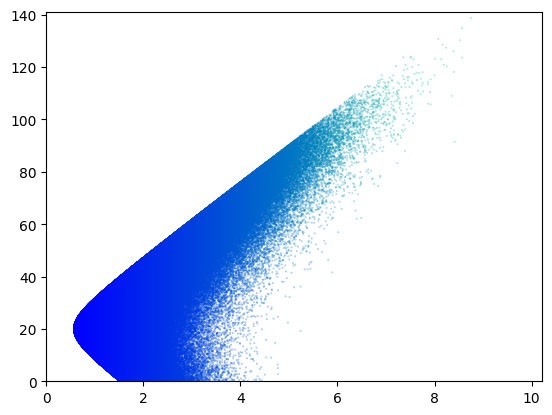



This is the result if we attempt to solve analytically
Best average return: 20.0
Minimum standard deviation: 0.3333333333333333
Best weights: [0.33 0.33 0.33]



In [10]:
#Q3
returns = [10, 20, 30]

covariances = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

### Method 1: Solves the Markovitz using a numerical trial-and-error approach. Most robust but helps primatily to check answers only
print("\n\nThis is the result if we attempt to solve stuff randomly")
markowitz_random(returns, covariances, shorting = True)

# Method 2: Solves the Markovitz using the multivariable calculus approach in the book
print("\n\nThis is the result if we attempt to solve analytically")
markowitz_analytical(returns, covariances)
print()

In [4]:
#Q3
import numpy as np

# Define the mean returns of the assets
mean_returns = np.array([0.10, 0.20, 0.30])

# The target mean return for the portfolio
target_return = 0.20

# Coefficients for the weights in the constraints
# We have two equations:
# w1 + w2 + w3 = 1 (all weights must sum up to 1)
# 0.10w1 + 0.20w2 + 0.30w3 = 0.20 (desired portfolio return)
A = np.array([[1, 1, 1], mean_returns])

# Constants in the equations
b = np.array([1, target_return])

# Solve for weights using the least squares method
# This function finds the weights that minimize the variance of the portfolio
weights, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

# Since we expect the solution to give us valid weights that sum up to 1 and give the target return,
# we don't expect any weight to be outside the range [0, 1].
# However, we check for it and if any weight is outside this range, we would need to adjust our approach.
# Given the constraints of the problem, this should not be the case.
if all(0 <= weight <= 1 for weight in weights):
    w1 = round(weights[0], 2)  # Round the weight of asset 1 to two decimal places
else:
    w1 = None  # If any weight is not valid, set w1 to None

print(weights)
w1  # This will output the weight for asset 1


[0.33333333 0.33333333 0.33333333]


0.33

In [6]:
#q4
returns = [10, 20, 30]  # in percentage terms
covariances = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

# Convert returns to decimals
expected_returns = [r / 100 for r in returns]
# Risk-free rate
risk_free_rate = 0.05

# Instantiate the OptimizeStockPortfolio class
optimizer = OptimizeStockPortfolio(expected_returns, covariances)

# Solve for the tangent portfolio weights
tangent_portfolio_weights = optimizer.solve_tan_analytical(risk_free_rate)

# Print the weight of asset 1 in the tangent portfolio
w1_tangent_portfolio = tangent_portfolio_weights[0]
print(f"Weight of asset 1 in the tangent portfolio: {w1_tangent_portfolio:.2f}")


Best average return: 0.24444444444444446
Minimum standard deviation: 0.4320987654320988
Best weights: [0.11 0.33 0.56]
Weight of asset 1 in the tangent portfolio: 0.11


In [7]:
#Q4
import numpy as np
from scipy.optimize import minimize

# Given data
mean_returns = np.array([0.10, 0.20, 0.30])
risk_free_rate = 0.05
variance_assets = 1  # Since variance is the same for all, it's factored out in Sharpe ratio

# Define the objective function to maximize the Sharpe ratio (which is equivalent to minimizing its negative)
def negative_sharpe_ratio(weights, mean_returns, risk_free_rate):
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_variance = np.sum(weights**2 * variance_assets)
    portfolio_std_dev = np.sqrt(portfolio_variance)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return -sharpe_ratio

# Define the constraints: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Define the bounds for the weights: no short selling is allowed
bounds = ((0, 1), (0, 1), (0, 1))

# Initial guess for the weights
initial_weights = np.array([1/3, 1/3, 1/3])

# Optimize the portfolio to find the weights that maximize the Sharpe ratio
optimal_weights = minimize(
    negative_sharpe_ratio,
    initial_weights,
    args=(mean_returns, risk_free_rate),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Print the optimal weights for the single fund F
optimal_weights.x.round(2)


array([0.11, 0.33, 0.56])



This is the result if we attempt to solve stuff randomly
Best average return: 14.337053348806322
Minimum standard deviation: 0.641377674219347
Best weights: [0.03 0.35 0.33 0.06 0.24]


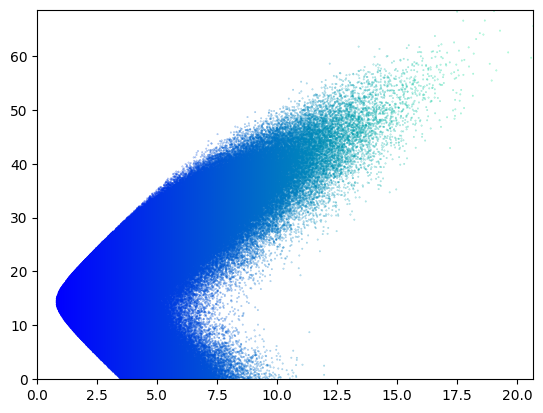



This is the result if we attempt to solve analytically
Best average return: 14.412865922482819
Minimum standard deviation: 0.6249392552670228
Best weights: [0.09 0.25 0.28 0.1  0.27]


Now assume the risk free rate is 10%


This is the result if we attempt to solve stuff randomly
Best average return: 17.20534398887242
Minimum standard deviation: 1.0568665567108337
Best weights: [ 0.35 -0.13  0.42 -0.12  0.48]


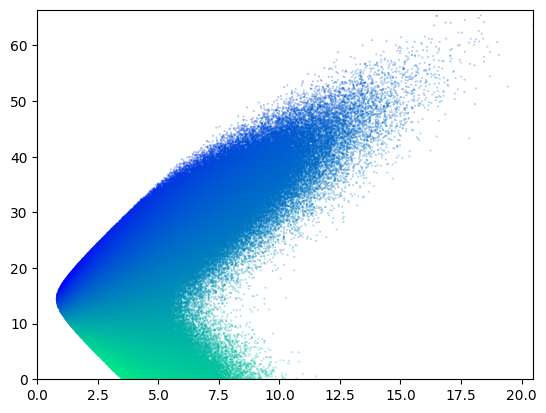



This is the result if we attempt to solve stuff analytically
Best average return: 16.989897881392707
Minimum standard deviation: 0.9898922045500025
Best weights: [ 0.32 -0.06  0.39 -0.11  0.47]


Suppose instead we want a target return of 25%. What is the lowest possible variance?
Best average return: 25.000000000000004
Minimum standard deviation: 6.784561730081626
Best weights: [ 1.03 -1.03  0.71 -0.78  1.07]



In [9]:
#Q5-6
import numpy as np
returns = [15.1, 12.5, 14.7, 9.02, 17.68]

cov = np.array([
    [ 2.30, 0.93,  0.62,  0.74, -0.23],
    [ 0.93, 1.40,  0.22,  0.56,  0.26],
    [ 0.62, 0.22,  1.80,  0.78, -0.27],
    [ 0.74, 0.56,  0.78,  3.40, -0.56],
    [-0.23, 0.26, -0.27, -0.56,  2.60]
])

np.random.seed(1)

print("\n\nThis is the result if we attempt to solve stuff randomly")
markowitz_random(returns, cov, shorting = True)

print("\n\nThis is the result if we attempt to solve analytically")
markowitz_analytical(returns, cov)

print("\n\nNow assume the risk free rate is 10%")
print("\n\nThis is the result if we attempt to solve stuff randomly")
markowitz_riskfree_random(returns, cov, 10)

print("\n\nThis is the result if we attempt to solve stuff analytically")
markowitz_riskfree_analytical(returns, cov, 10)

print("\n\nSuppose instead we want a target return of 25%. What is the lowest possible variance?")
markowitz_fixed_mean_analytical(returns, cov, 25)
print()

In [12]:
#Q5
import numpy as np

# Convert returns to decimals
returns = [0.151, 0.125, 0.147, 0.0902, 0.1768]

# Adjust covariance matrix as per the problem statement
cov = np.array([
    [ 2.30, 0.93,  0.62,  0.74, -0.23],
    [ 0.93, 1.40,  0.22,  0.56,  0.26],
    [ 0.62, 0.22,  1.80,  0.78, -0.27],
    [ 0.74, 0.56,  0.78,  3.40, -0.56],
    [-0.23, 0.26, -0.27, -0.56,  2.60]
]) / 100  # Dividing by 100 as per the problem statement

# Risk-free rate in decimals
risk_free_rate = 0.10

# Function calls (assuming they are defined elsewhere in your code)
# This function will print the weights of the tangent portfolio
markowitz_riskfree_analytical(returns, cov, risk_free_rate)


Best average return: 0.16989897881392704
Minimum standard deviation: 0.009898922045500023
Best weights: [ 0.32 -0.06  0.39 -0.11  0.47]


array([ 0.31719998, -0.06108573,  0.38650446, -0.11127402,  0.46865531])

In [8]:
import numpy as np
from scipy.optimize import minimize

# Define the expected returns and the covariance matrix in decimal form
returns = np.array([0.151, 0.125, 0.147, 0.0902, 0.1768])
cov = np.array([
    [23.0,  9.3,  6.2,  7.4, -2.3],
    [ 9.3, 14.0,  2.2,  5.6,  2.6],
    [ 6.2,  2.2, 18.0,  7.8, -2.7],
    [ 7.4,  5.6,  7.8, 34.0, -5.6],
    [-2.3,  2.6, -2.7, -5.6, 26.0]
]) / 100  # Convert to decimals
risk_free_rate = 0.10  # Convert to decimal

# Define the objective function for the Sharpe ratio
def negative_sharpe_ratio(weights, returns, cov, risk_free_rate):
    portfolio_return = np.dot(weights, returns)
    portfolio_variance = np.dot(weights, np.dot(cov, weights))
    portfolio_std_dev = np.sqrt(portfolio_variance)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return -sharpe_ratio

# Constraints: the weights must sum to 1
constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]

# Allow short selling by having no bounds on weights
bounds = tuple((None, None) for asset in returns)

# Initial guess for the weights
initial_weights = np.full(len(returns), 1/len(returns))

# Optimization to find the weights that maximize the Sharpe ratio
result = minimize(
    negative_sharpe_ratio,
    initial_weights,
    args=(returns, cov, risk_free_rate),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# The optimal weights for maximizing the Sharpe ratio
optimal_weights = result.x

# Calculate the portfolio variance using the optimal weights
portfolio_variance = optimal_weights.T @ cov @ optimal_weights

# Output the results
optimal_weights_rounded = np.round(optimal_weights, 2)
portfolio_variance_rounded = round(portfolio_variance, 4)

(optimal_weights_rounded, portfolio_variance_rounded)
#portfolio_variance_rounded is not right, see the down side solution.

(array([ 0.32, -0.06,  0.39, -0.11,  0.47]), 0.0989)

In [11]:
#Q6
import numpy as np

# Given weights of the securities in the portfolio
weights = np.array([0.32, -0.06, 0.39, -0.11, 0.47])

# Given covariance matrix of the securities
covariance_matrix = np.array([
    [2.30, 0.93, 0.62, 0.74, -0.23],
    [0.93, 1.40, 0.22, 0.56, -0.26],
    [0.62, 0.22, 1.80, 0.78, -0.27],
    [0.74, 0.56, 0.78, 3.40, -0.56],
    [-0.23, -0.26, -0.27, -0.56, 2.60]
])

# Converting the covariance matrix to the correct scale (percent^2)
covariance_matrix = covariance_matrix / 100

# Calculating the portfolio variance
portfolio_variance = np.dot(weights, np.dot(covariance_matrix, weights))

# Rounding the portfolio variance to four decimal places
portfolio_variance_rounded = round(portfolio_variance, 4)

portfolio_variance_rounded


0.0103

In [12]:
portfolio_std_dev = np.sqrt(portfolio_variance)
portfolio_std_dev

0.10155481278600242